In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf

## Part I: The Return Distribution

In [7]:
end_date = '2025-06-29'
start_date = '2019-06-28'
tickers = ['JPM']

In [8]:
def get_price_data(tickers, start_date, end_date, interval='1d'):
    data = yf.download(tickers=tickers, start=start_date, end=end_date)
    data = data.reset_index()
    data.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in data.columns]
    data.columns = ['date', 'close', 'high', 'low', 'open', 'volume']
    data['close_lag'] = data['close'].shift(1)
    data['return'] = (data['close'] / data['close_lag']) - 1
    data['log_return'] = np.log(data['close'] / data['close_lag'])
    keep_columns = ['date','return','log_return']
    return data.loc[1:, keep_columns]

def return_statistics(returns):
    returns = np.array(returns)

    mean = np.mean(returns)
    variance = np.var(returns)
    std_dev = np.std(returns)

    if len(returns) > 1:
        autocorr = np.corrcoef(returns[:-1], returns[1:])[0, 1]
    else:
        autocorr = np.nan
    
    skewness = stats.skew(returns)
    excess_kurtosis = stats.kurtosis(returns)

    shapiro_test = stats.shapiro(returns)
    jarque_bera_test = stats.jarque_bera(returns)

    results = {
        'mean':mean,
        'variance': variance,
        'std_dev': std_dev,
        'autocorrelation': autocorr,
        'skewness': skewness,
        'excess_kurtosis': excess_kurtosis,
        'shapiro_test': shapiro_test,
        'jarque_bera_test': jarque_bera_test
    }

    return results

def plot_returns(returns):
    returns = np.array(returns)

    fig, axes = plt.subplots(2,2, figsize=(14,10))

    sns.histplot(returns, kde=True, ax=axes[0, 0])
    x = np.linspace(min(returns), max(returns), 100)
    y = stats.norm.pdf(x, np.mean(returns), np.std(returns))
    axes[0,0].plot(x, y * len(returns) * (max(returns) - min(returns)) / 10, 'r-', lw=2)
    axes[0,0].set_title('Return Distribution vs Normal Distribution')

    sm.qqplot(returns, line='s', ax=axes[0,1])
    axes[0,1].set_title('QQ-Plot')

    axes[1,0].plot(returns)
    axes[1,0].set_title('Return Time Series')

    plot_acf(returns, lags=20, ax=axes[1,1])
    axes[1, 1].set_title("ACF Plot")

    plt.tight_layout()
    plt.show()

def print_return_statistics(results):
    print("=== Stock Return Analysis ===")
    print(f"Mean: {results['mean']:.6f}")
    print(f"Variance: {results['variance']:.6f}")
    print(f"Standard Deviation: {results['std_dev']:.6f}")
    print(f"Autocorrelation (lag 1): {results['autocorrelation']:.6f}")
    print(f"Skewness: {results['skewness']:.6f}")
    print(f"Excess Kurtosis: {results['excess_kurtosis']:.6f}")
    print("\n=== Normality Tests ===")
    print(f"Shapiro-Wilk Test: statistic={results['shapiro_test'][0]:.6f}, p-value={results['shapiro_test'][1]:.6f}")
    print(f"Jarque-Bera Test: statistic={results['jarque_bera_test'][0]:.6f}, p-value={results['jarque_bera_test'][1]:.6f}")
    # Interpret normality test results
    alpha = 0.05
    if results['shapiro_test'][1] < alpha or results['jarque_bera_test'][1] < alpha:
        print("\nInterpretation: There is evidence to reject the null hypothesis that the returns follow a normal distribution.")
    else:
        print("\nInterpretation: There is insufficient evidence to reject the null hypothesis that the returns follow a normal distribution.")

In [9]:
data = get_price_data(tickers, start_date, end_date)

/tmp/ipykernel_22762/3682126178.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [10]:
data.head()

,date,return,log_return
1,2019-07-01,0.016816,0.016676
2,2019-07-02,0.001056,0.001055
3,2019-07-03,-0.001593,-0.001594
4,2019-07-05,0.005939,0.005921
5,2019-07-08,-0.005463,-0.005478


=== Stock Return Analysis ===
Mean: 0.000934
Variance: 0.000389
Standard Deviation: 0.019729
Autocorrelation (lag 1): -0.118666
Skewness: 0.358364
Excess Kurtosis: 12.944092

=== Normality Tests ===
Shapiro-Wilk Test: statistic=0.875894, p-value=0.000000
Jarque-Bera Test: statistic=10552.969592, p-value=0.000000

Interpretation: There is evidence to reject the null hypothesis that the returns follow a normal distribution.


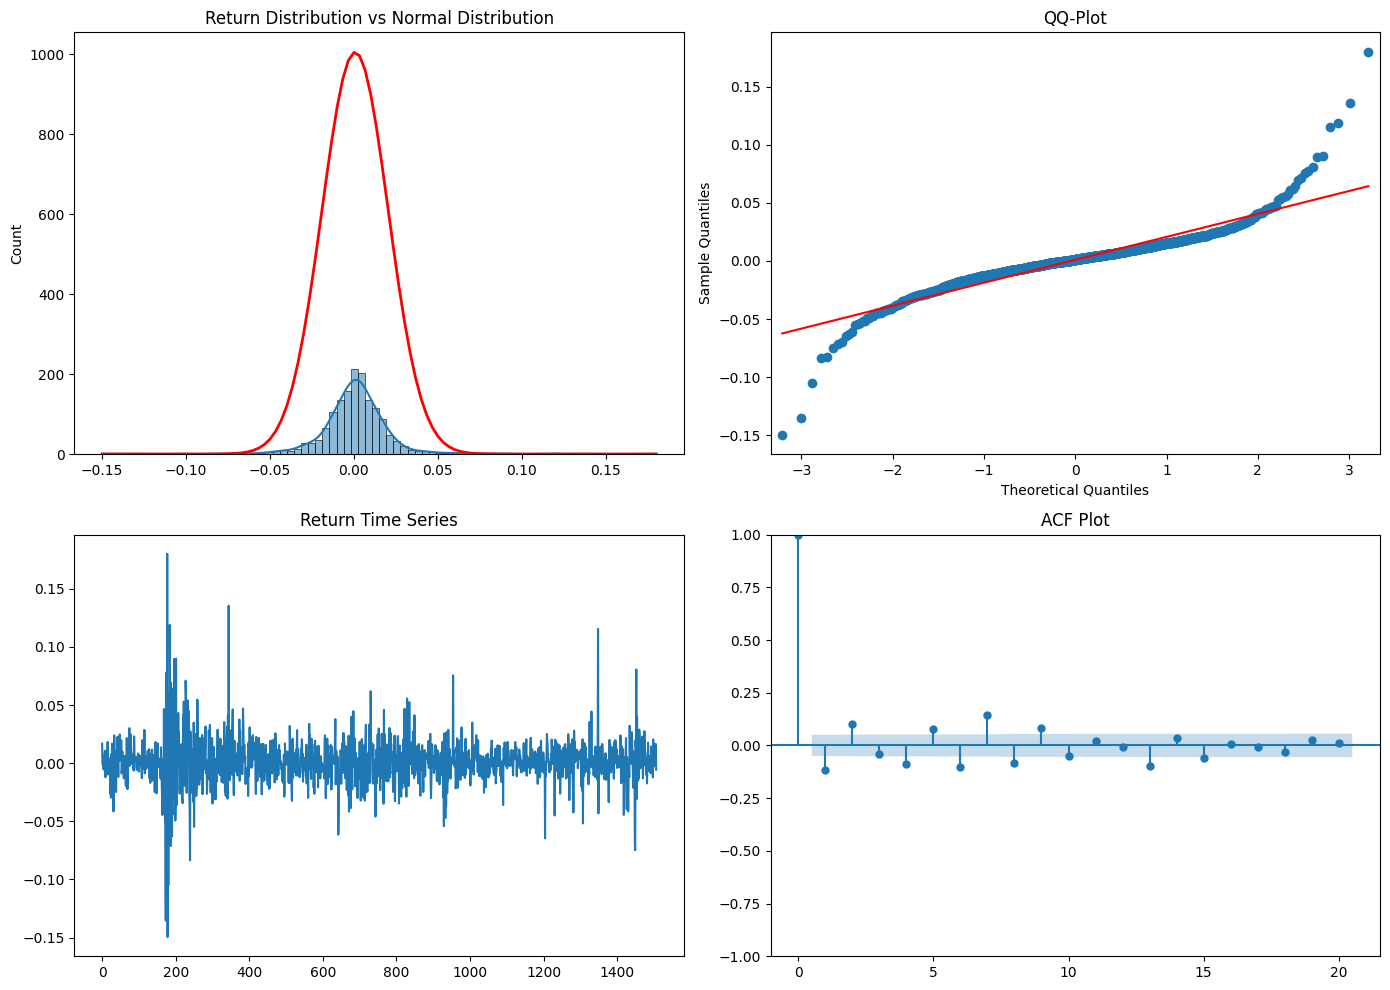

In [16]:
var = 'return'
results = return_statistics(data[var])
print_return_statistics(results)
plot_returns(data[var])

=== Stock Return Analysis ===
Mean: 0.000739
Variance: 0.000388
Standard Deviation: 0.019695
Autocorrelation (lag 1): -0.115766
Skewness: -0.073229
Excess Kurtosis: 12.570466

=== Normality Tests ===
Shapiro-Wilk Test: statistic=0.877445, p-value=0.000000
Jarque-Bera Test: statistic=9923.473610, p-value=0.000000

Interpretation: There is evidence to reject the null hypothesis that the returns follow a normal distribution.


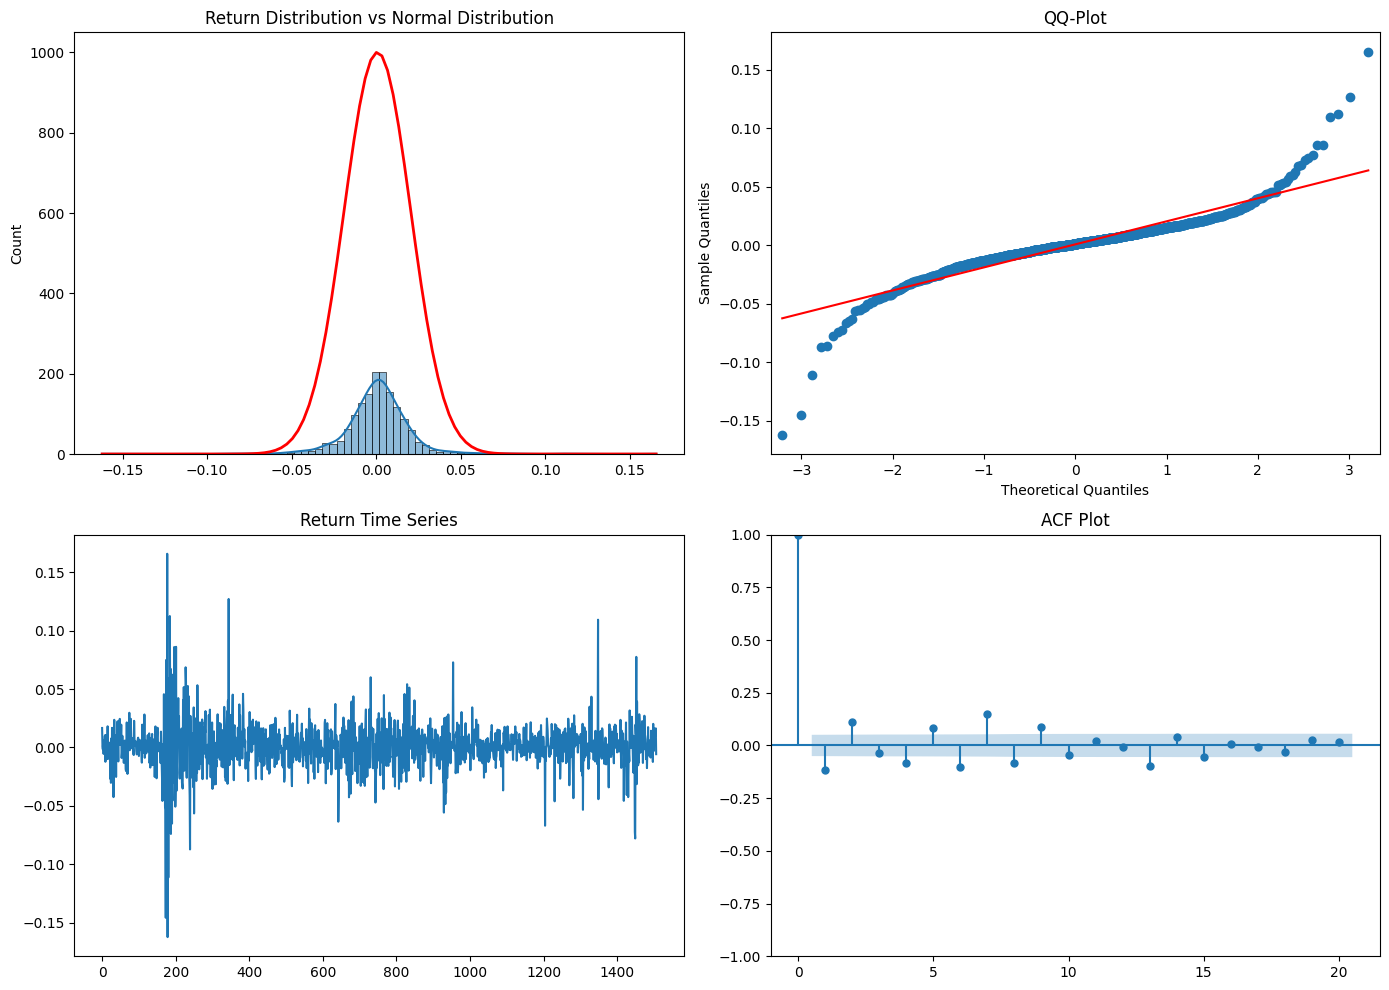

In [17]:
var = 'log_return'
results = return_statistics(data[var])
print_return_statistics(results)
plot_returns(data[var])

Both daily return and log(daily return) dont follow the normal distribution. We can see that log returns has lesser skew compared to the daily return, therfore log return is closer to normality

## Part II: Estimate CAPM Beta

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import yfinance as yf
from datetime import datetime, timedelta

In [48]:
def get_monthly_returns(ticker, market_index='SPY', start_date=start_date, end_date=end_date):
    ticker = 'JPM'
    market_index = 'SPY'

    stock_data = yf.download(ticker, start=start_date, end=end_date)
    market_data = yf.download(market_index, start=start_date, end=end_date)

    stock_monthly = stock_data['Close'].resample('MS').last()
    market_monthly = market_data['Close'].resample('MS').last()

    stock_returns = stock_monthly.pct_change().dropna()
    market_returns = market_monthly.pct_change().dropna()

    returns_df = stock_returns.merge(market_returns, on='Date')
    return returns_df

In [49]:
start_date = '2019-05-01'
end_date = '2025-06-01'
monthly_data = get_monthly_returns('JPM', start_date=start_date, end_date=end_date)
print(monthly_data.shape)
monthly_data.head()

/tmp/ipykernel_22762/1984253444.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_22762/1984253444.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download(market_index, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

(72, 2)


Ticker,JPM,SPY
Date,,
2019-06-01,0.055115,0.069586
2019-07-01,0.044913,0.015119
2019-08-01,-0.052931,-0.016743
2019-09-01,0.071272,0.019458
2019-10-01,0.069936,0.022104


In [54]:
tbill_data = pd.read_csv("./data/TB4WK.csv")
tbill_data.columns = ['Date', 'T-Bill']
tbill_data['Date'] = pd.to_datetime(tbill_data['Date'], format='%Y-%m-%d')
tbill_data = tbill_data.set_index('Date')
tbill_monthly = tbill_data['T-Bill'].resample('MS').last()
tbill_returns = tbill_monthly.pct_change().dropna()
tbill_returns.head()

Date
2019-02-01    0.012712
2019-03-01    0.008368
2019-04-01   -0.012448
2019-05-01   -0.008403
2019-06-01   -0.076271
Freq: MS, Name: T-Bill, dtype: float64